# 0.0. IMPORTS

In [1]:
import math
import inflection
import warnings
import datetime
import pickle 
import random
import json
import requests

import pandas                  as pd
import numpy                   as np
      
import seaborn                 as sns
import matplotlib.pyplot       as plt
import xgboost                 as xgb

from boruta                    import BorutaPy
from scipy                     import stats  as ss
from IPython.display           import Image
from IPython.core.display      import HTML
from matplotlib                import gridspec
from tabulate                  import tabulate

from sklearn                   import metrics as mt
from sklearn.preprocessing     import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble          import RandomForestRegressor
from sklearn.linear_model      import LinearRegression, Lasso

#--
warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print(f'\n KFold Number: {k}')
        # start and end date validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7 )
        validation_end_date   = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7 )
        
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[ (x_training['date'] >= validation_start_date ) & (x_training['date'] <= validation_end_date) ]
        
        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
        
        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']
        
        # model
        m = model.fit( xtraining, ytraining )
        
        # prediction
        yhat = m.predict( xvalidation )
        
        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )
    
        # armazenando desempenho de cada iteracao kfold
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE CV': np.round( np.mean( mae_list ), 2).astype( str ) +  ' +/- ' + np.round( np.std( mae_list ), 2).astype( str ),
                           'MAPE CV': np.round( np.mean( mape_list ), 2).astype( str ) +  ' +/- ' + np.round( np.std( mape_list ), 2).astype( str ),
                           'RMSE CV': np.round( np.mean( rmse_list ), 2).astype( str ) +  ' +/- ' + np.round( np.std( rmse_list ), 2).astype( str ) }, index=[0] )

def ml_error( model_name, y, yhat ):
    mae = mt.mean_absolute_error( y, yhat )
    mape = mt.mean_absolute_percentage_error( y, yhat ) 
    rmse = mt.mean_squared_error( y, yhat, squared=False )

    return pd.DataFrame( { 'Model Name': model_name,
                            'MAE':  mae,
                            'MAPE': mape,
                            'RMSE': rmse }, index=[0] )

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat) / y )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1) ) )

def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'tableau-colorblind10' )
    plt.rcParams['figure.figsize'] = [16, 9]
    plt.rcParams['font.size'] = 14
    
    display( HTML( '<style>.container { width:90% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

In [4]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


## 0.2. Loading Data

In [5]:
df_sales_raw = pd.read_csv( 'datasets/train.csv',low_memory=False )
df_store_raw = pd.read_csv( 'datasets/store.csv',low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

#estilo minusculo separado por (_)
snakecase = lambda x: inflection.underscore( x )

# A funcao map faz o mapeamento da funcao snakecase em todas as palavras da cols_old
cols_new = list( map(snakecase, cols_old) )

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [8]:
print( f'Number of Rows: {df1.shape[0]}')
print( f'Number of Cols: {df1.shape[1]}')

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [9]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum().sort_values( ascending=False )

promo_interval                  508031
promo2_since_year               508031
promo2_since_week               508031
competition_open_since_year     323348
competition_open_since_month    323348
competition_distance              2642
day_of_week                          0
promo2                               0
assortment                           0
store                                0
school_holiday                       0
state_holiday                        0
promo                                0
open                                 0
customers                            0
sales                                0
date                                 0
store_type                           0
dtype: int64

## 1.5. Fillout NA

In [11]:
dist_max = df1['competition_distance'].max()
dist_min = df1['competition_distance'].min()

print( f'Distancia Máxima: {dist_max}')
print( f'Distancia Mínima: {dist_min}')

Distancia Máxima: 75860.0
Distancia Mínima: 20.0


In [12]:
# promo_interval      
month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

# fillma substitui os valores da coluna por 0 e o inplace=True, faz a modificacao direto na coluna
df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

# promo2_since_year 
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1)


# promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)

# competition_open_since_year   
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )


# competition_open_since_month    
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

# competition_distance       
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

In [13]:
df1.sample(5).T

,474458,612294,751045,1011825,810437
store,254,945,321,191,618
day_of_week,5,1,2,6,5
date,2014-05-02 00:00:00,2013-12-30 00:00:00,2013-08-27 00:00:00,2013-01-05 00:00:00,2013-07-05 00:00:00
sales,4337,5309,6191,7385,7745
customers,374,653,576,689,573
open,1,1,1,1,1
promo,1,0,1,0,1
state_holiday,0,0,0,0,0
school_holiday,0,1,0,0,0
store_type,d,a,c,a,d


In [14]:
df1.isna().sum().sort_values( ascending=False )

store                           0
day_of_week                     0
month_map                       0
promo_interval                  0
promo2_since_year               0
promo2_since_week               0
promo2                          0
competition_open_since_year     0
competition_open_since_month    0
competition_distance            0
assortment                      0
store_type                      0
school_holiday                  0
state_holiday                   0
promo                           0
open                            0
customers                       0
sales                           0
date                            0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [15]:
# competition
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )

# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7. Descriptive Statiscal

In [16]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

In [17]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std )).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = [ 'attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


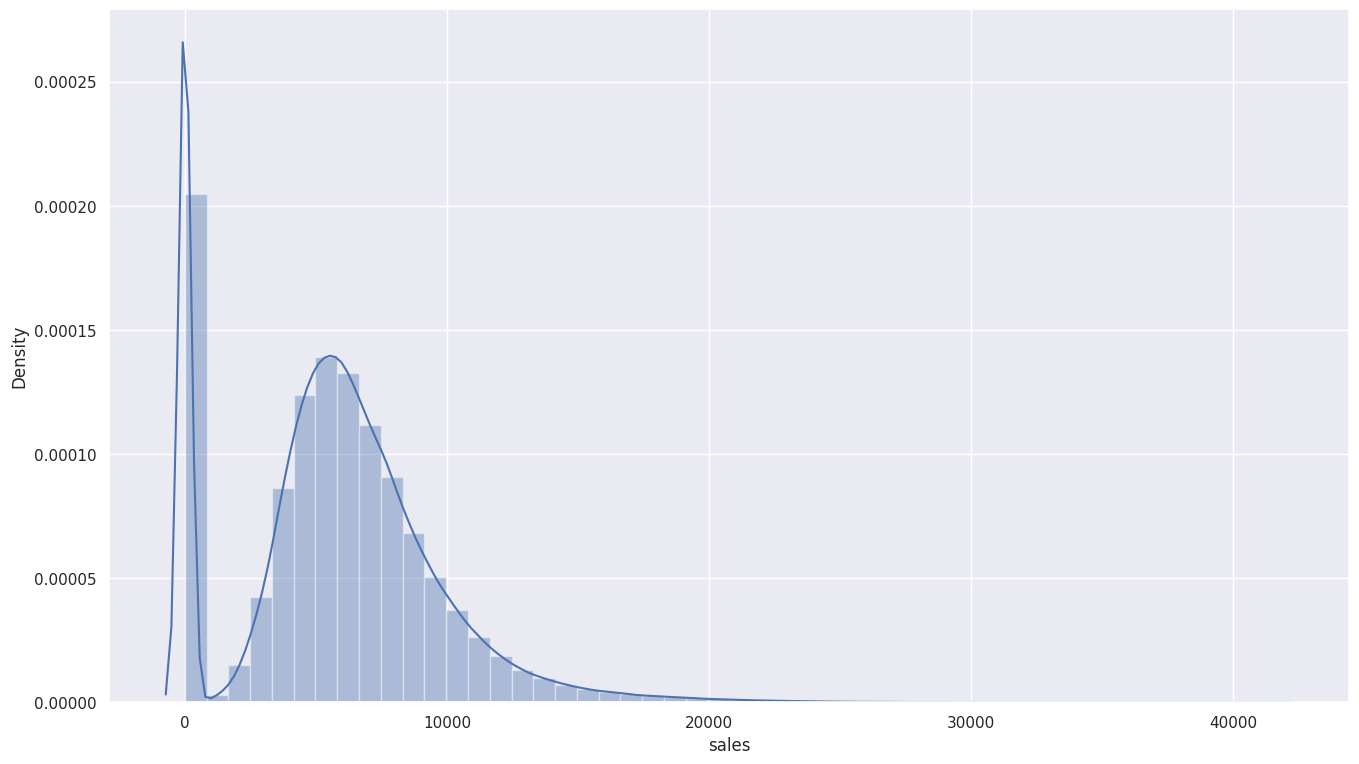

In [18]:
sns.distplot(df1['sales']);

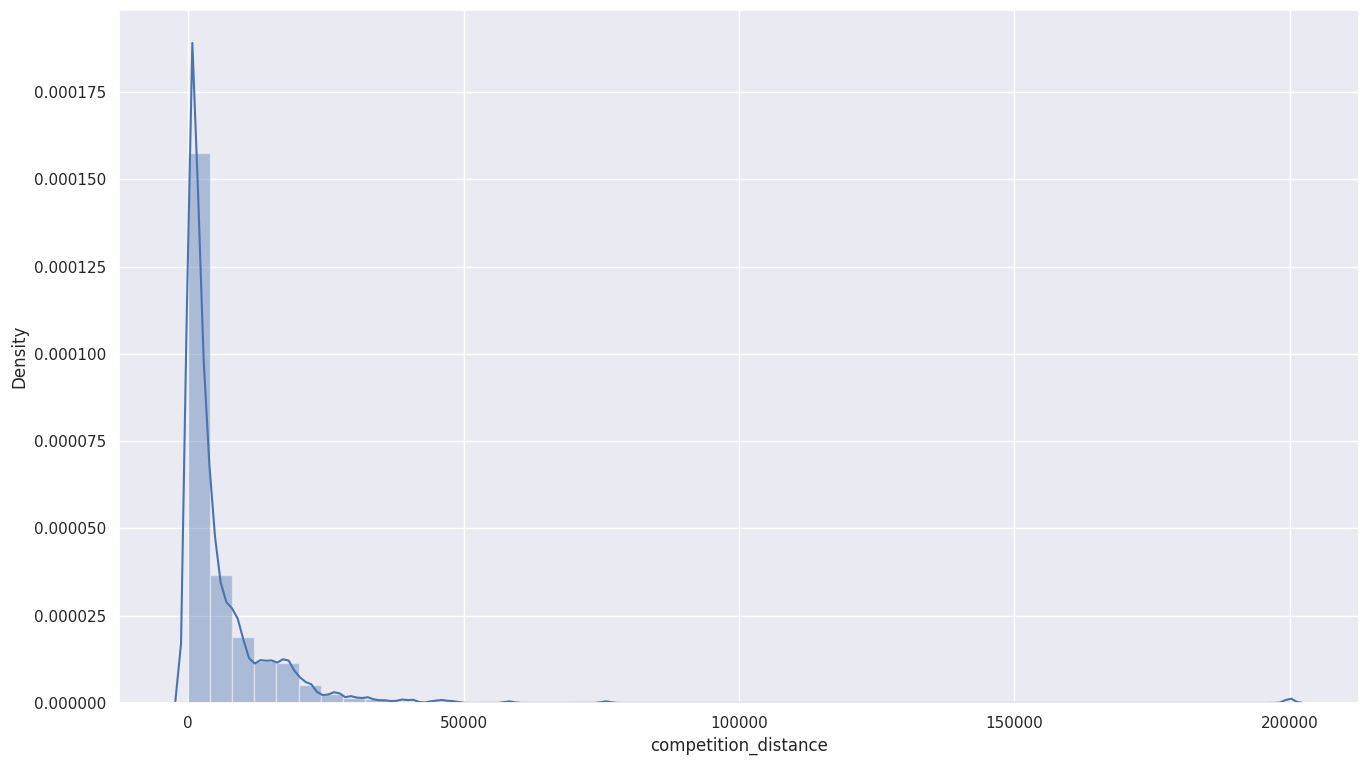

In [19]:
sns.distplot(df1['competition_distance']);

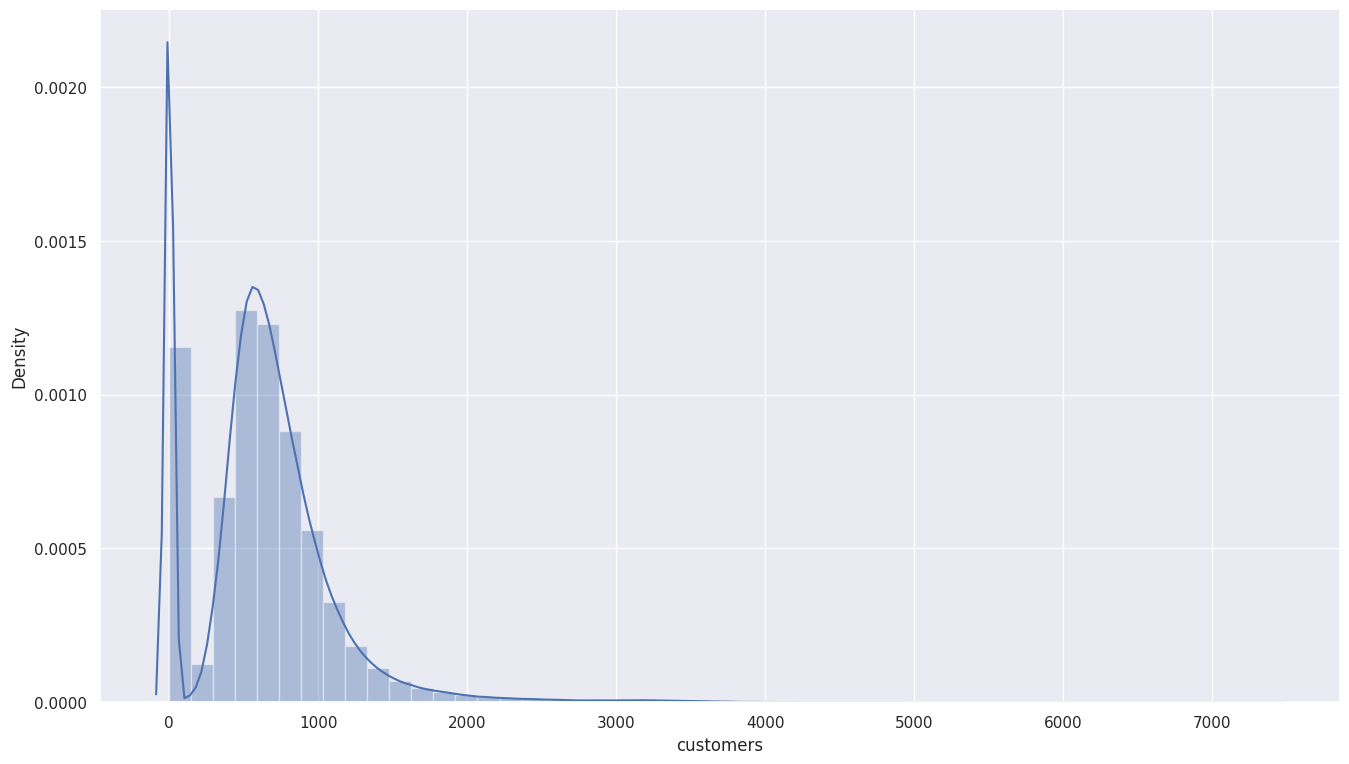

In [20]:
sns.distplot(df1['customers']);

## 1.7.2 Categorical Attributes

In [21]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

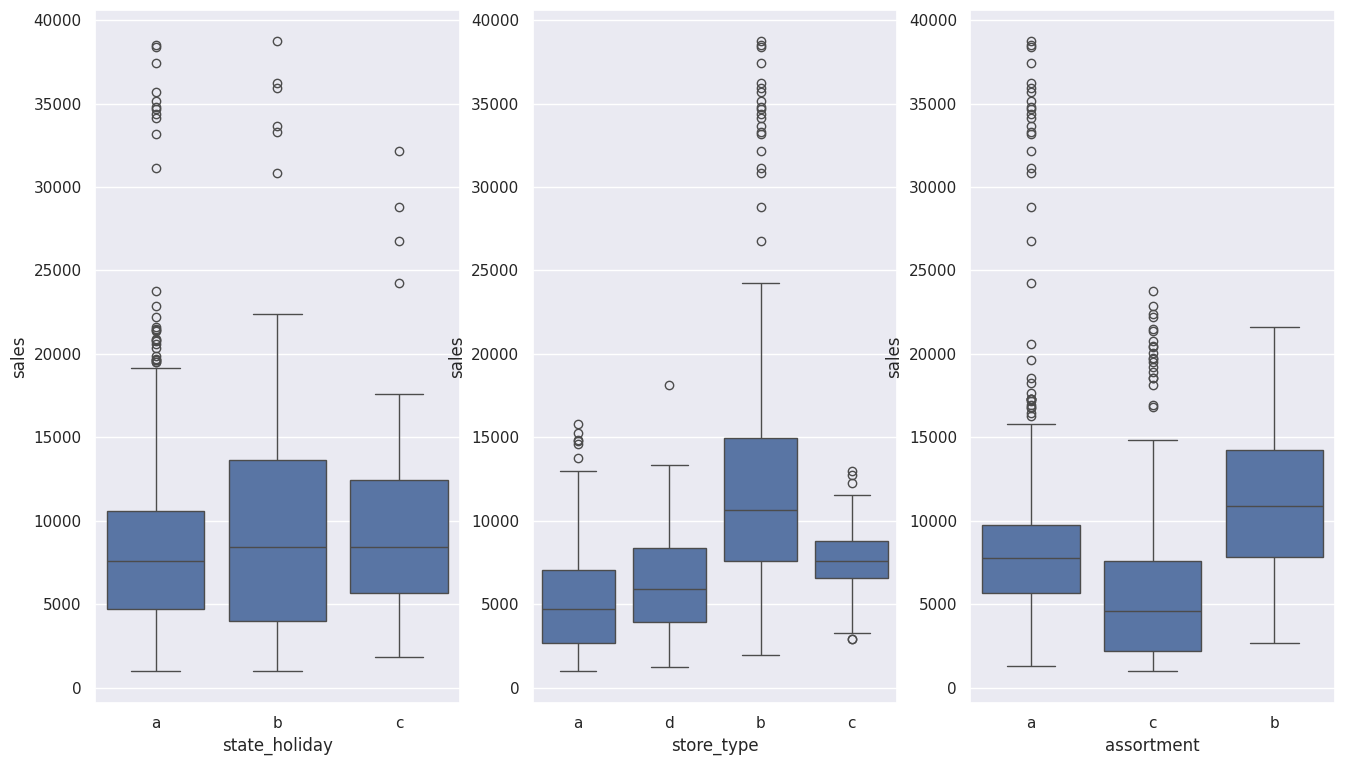

In [22]:
aux1 = df1[ ( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 ) ] 

plt.subplot( 1, 3, 1)
sns.boxplot( x='state_holiday' , y='sales' , data=aux1 )

plt.subplot( 1, 3, 2)
sns.boxplot( x='store_type' , y='sales' , data=aux1 )

plt.subplot( 1, 3, 3)
sns.boxplot( x='assortment' , y='sales' , data=aux1 );

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [23]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipoteses

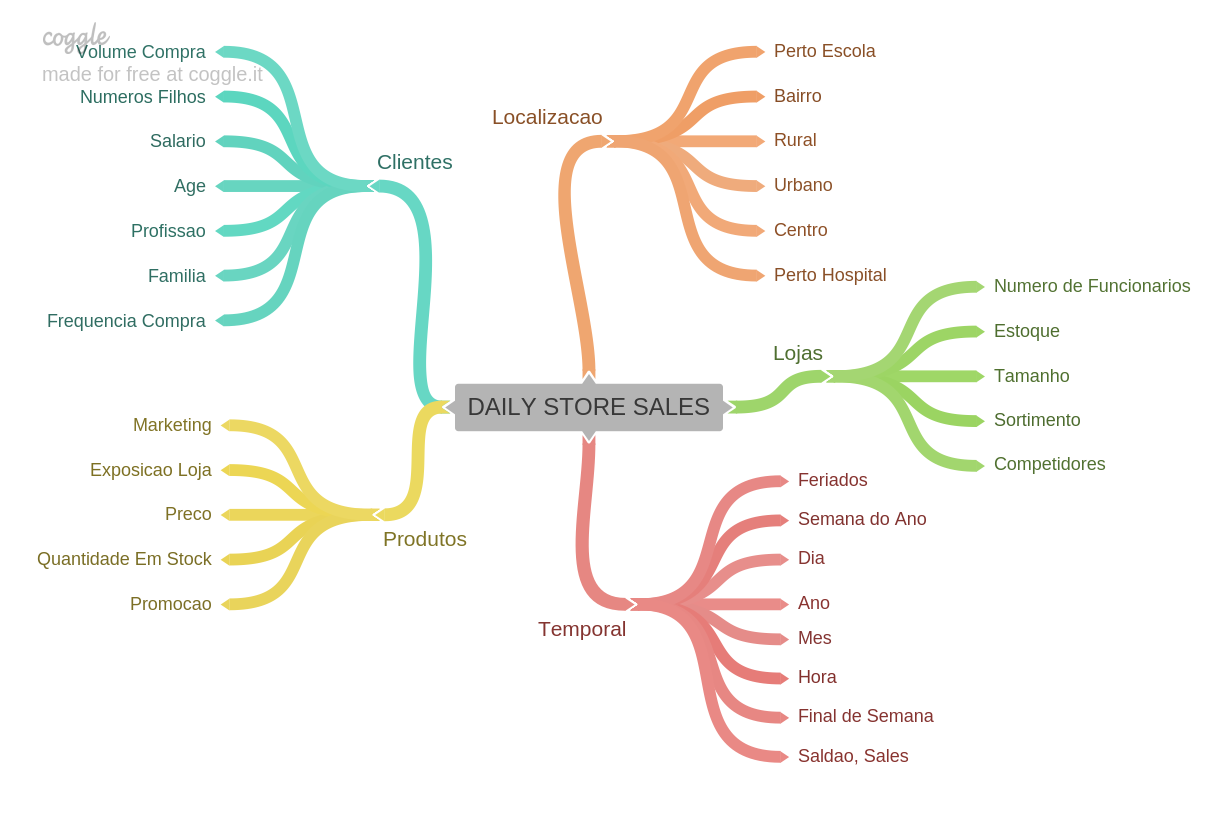

In [24]:
Image('img/MindMapHypothesis.png')

## 2.2. Criacao das Hipoteses

### 2.2.1 Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipoteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.


## 2.4. Feature Engineering

In [25]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year of week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7 ).apply( lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b'  else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [26]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [27]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [28]:
df3 = df3[ (df3['open']  != 0) & (df3['sales'] > 0) ]

## 3.2. Seleção das Colunas

In [29]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0. PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [30]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Variável Resposta

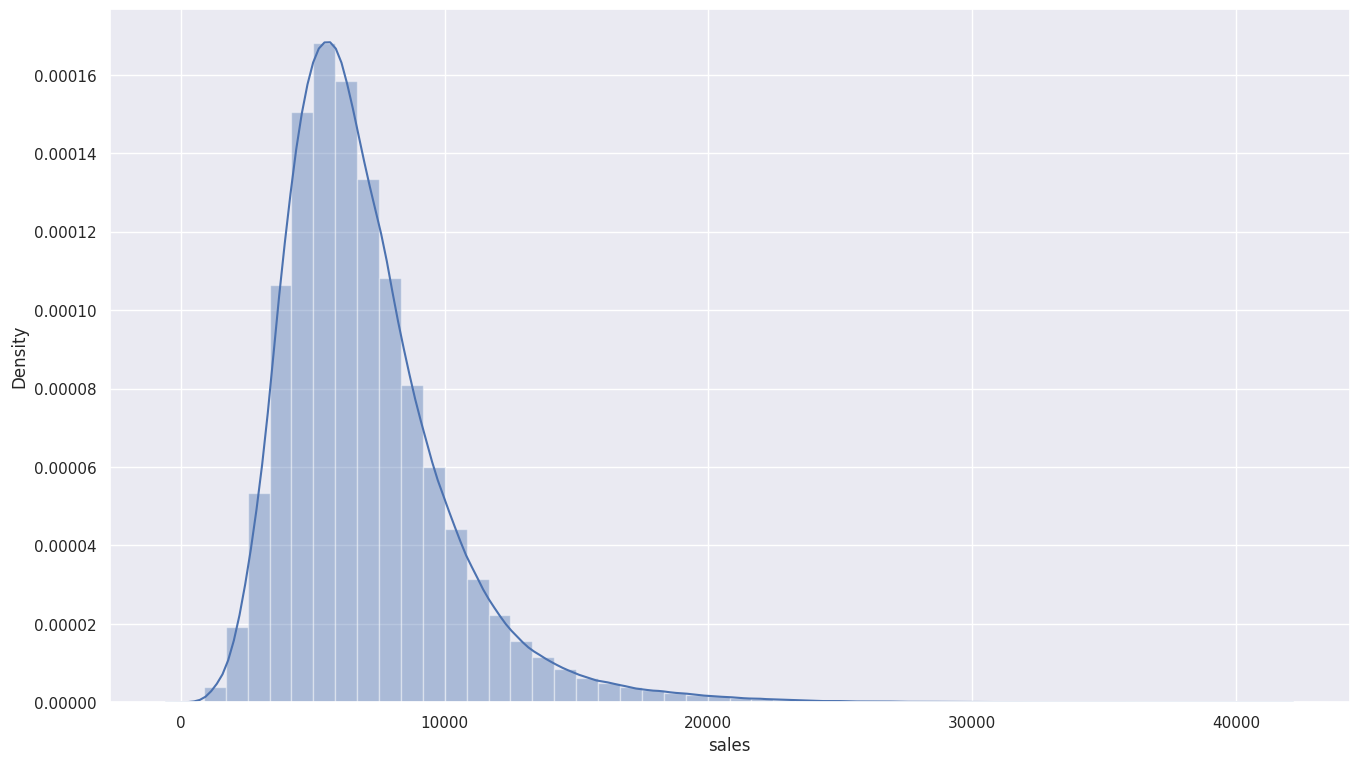

In [31]:
sns.distplot( df4['sales'], kde=True );

### 4.1.2. Variável Numérica

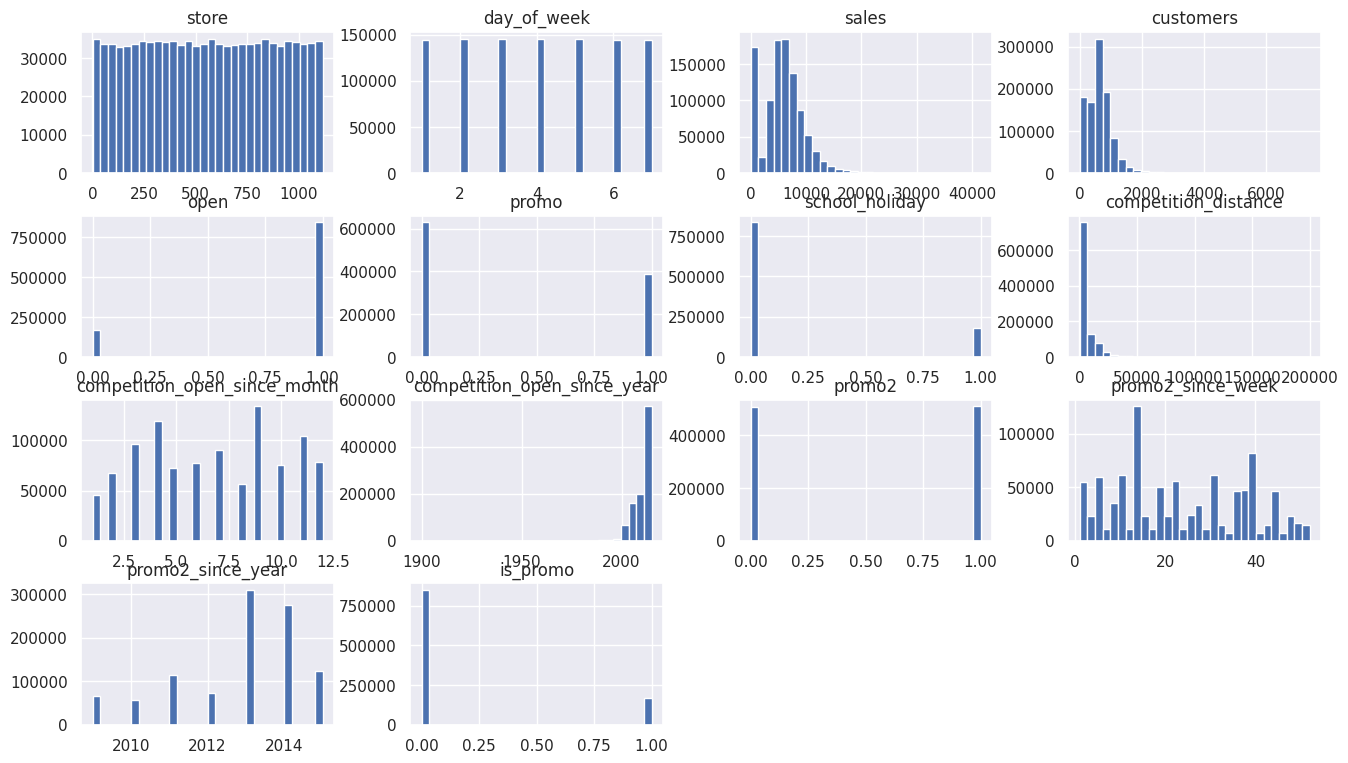

In [32]:
num_attributes.hist(bins=30)
plt.show();

### 4.1.3. Variável Categórica

In [33]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

In [34]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


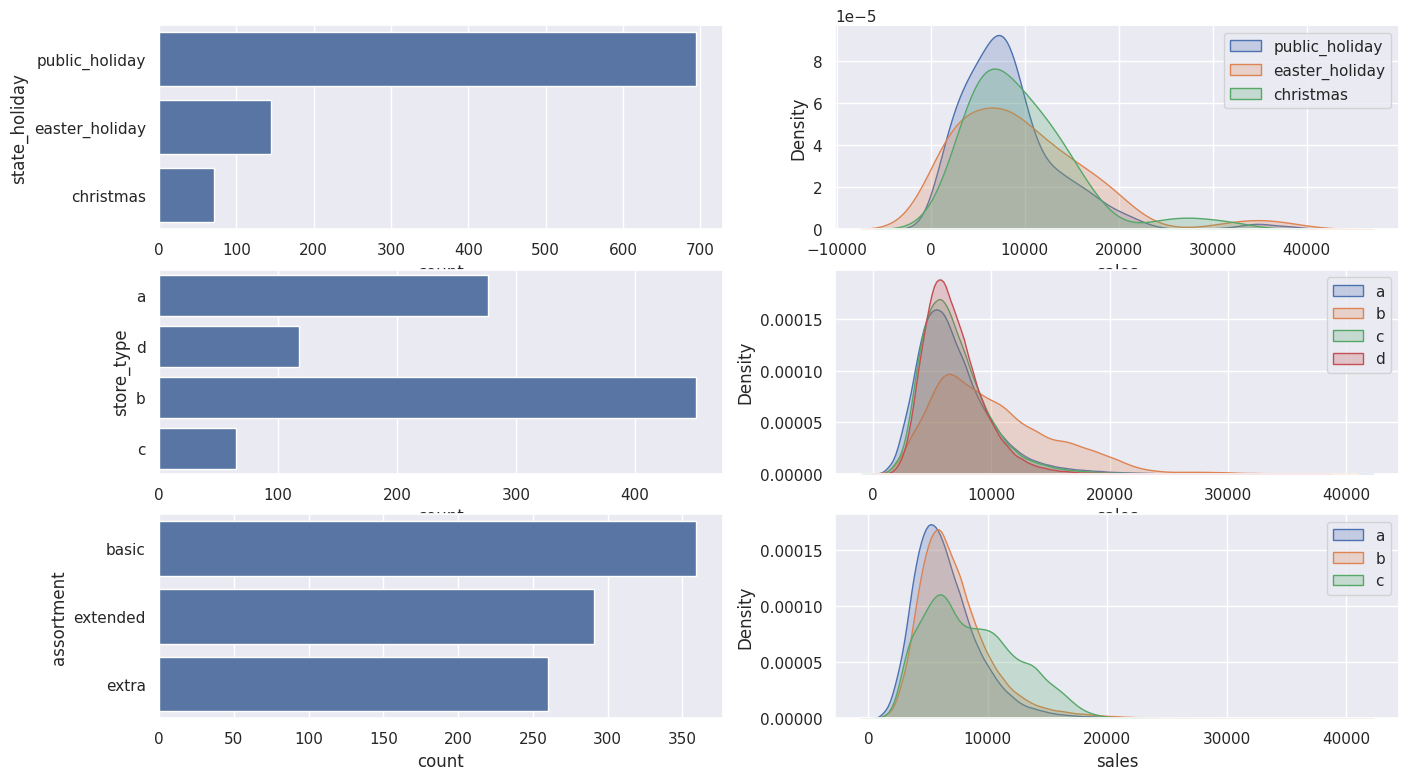

In [35]:
# state_holiday
plt.subplot(3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day' ]
sns.countplot( a['state_holiday'] );

plt.subplot(3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label= 'public_holiday', shade=True).legend()
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label= 'easter_holiday', shade=True ).legend()
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label= 'christmas', shade=True ).legend()


#store_type
plt.subplot(3, 2, 3 )
sns.countplot( a['store_type'] );

plt.subplot(3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label= 'a', shade=True ).legend()
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label= 'b', shade=True ).legend()
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label= 'c', shade=True ).legend()
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label= 'd', shade=True ).legend()


# Assortment
plt.subplot(3, 2, 5 )
sns.countplot( a['assortment'] );

plt.subplot(3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label= 'a', shade=True ).legend()
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label= 'b', shade=True ).legend()
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label= 'c', shade=True ).legend();

## 4.2. Analise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS

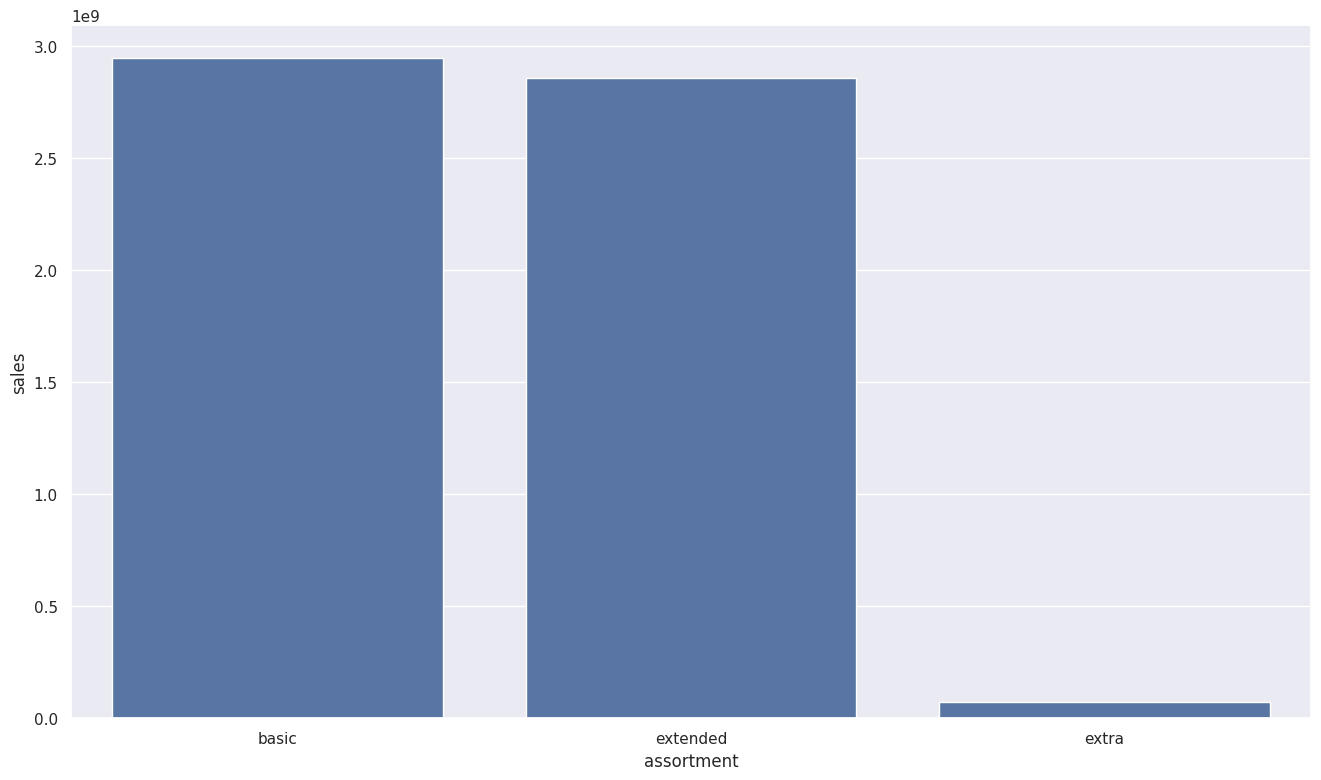

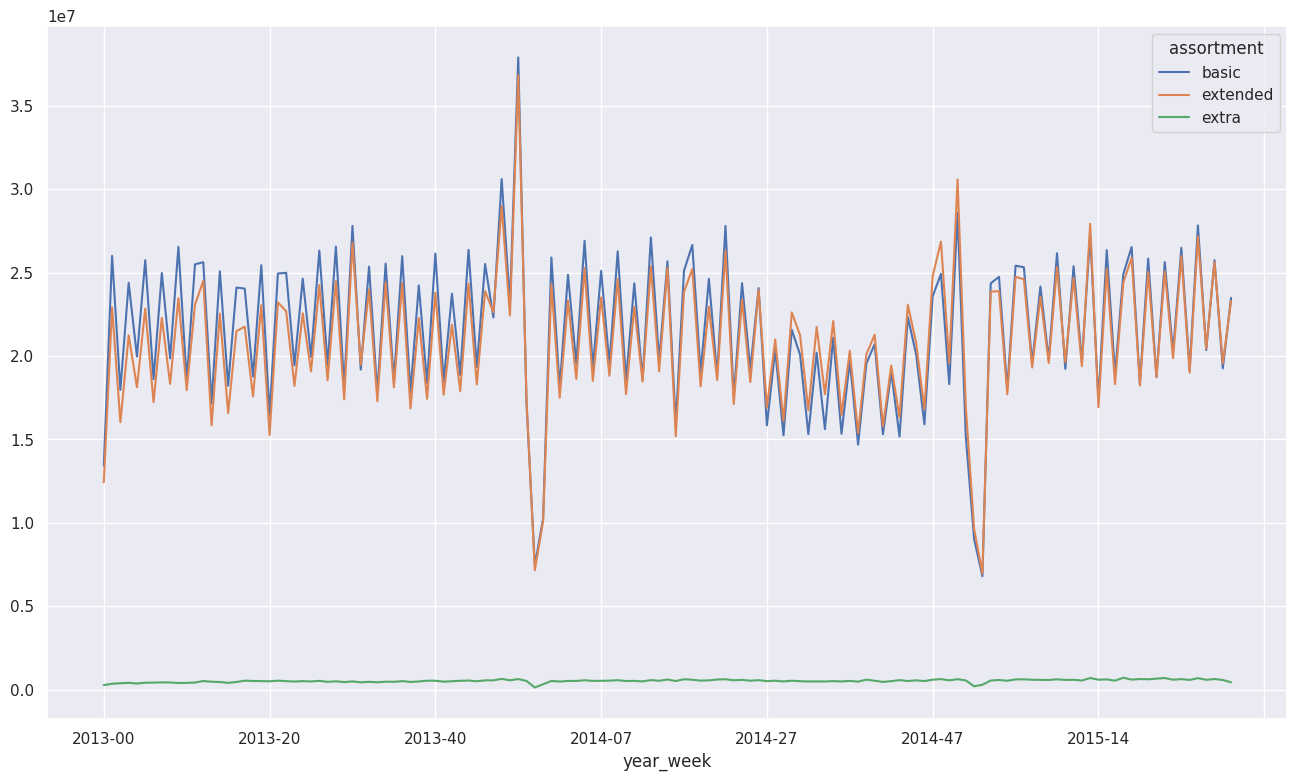

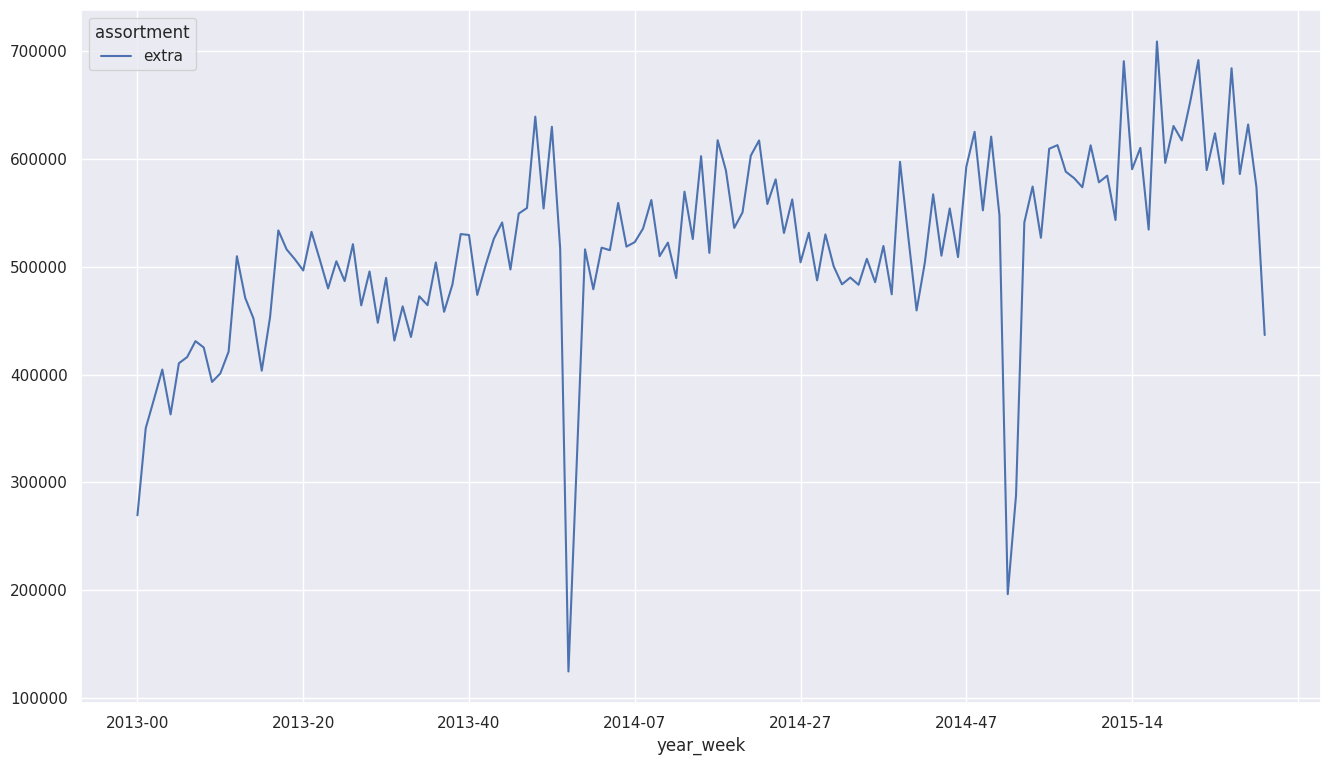

In [36]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot();

aux3 = aux2[ aux2['assortment'] == 'extra' ]
aux3 = aux3.pivot( index='year_week', columns='assortment', values='sales').plot();

### **H2.** Lojas com competidores mais próximos deveriam vender menos.

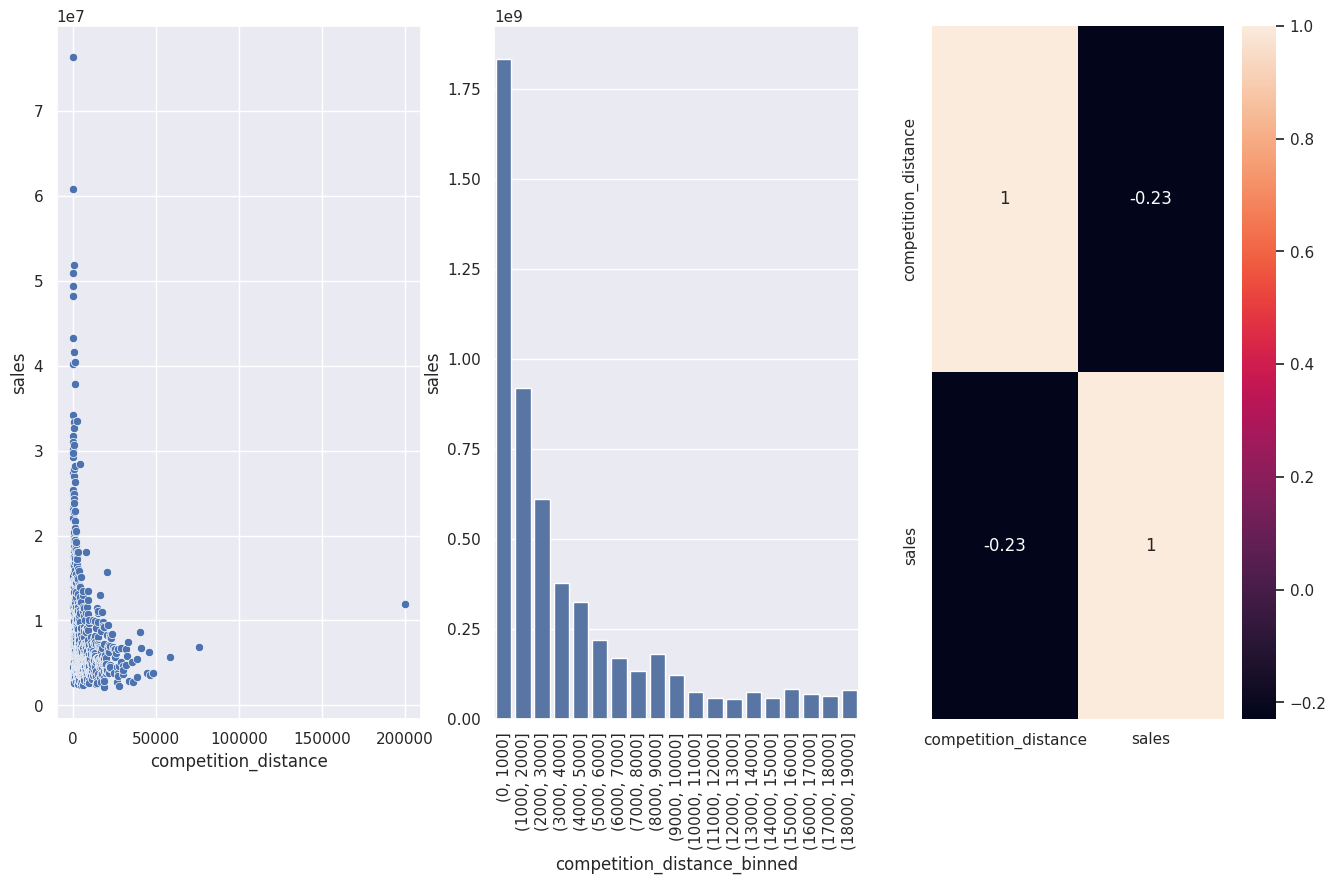

In [37]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1,3,1 )
sns.scatterplot( x='competition_distance', y='sales', data=aux1 );

plt.subplot( 1,3,2 )
bins = list( np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks( rotation=90);

plt.subplot( 1,3,3 )
correlation = aux1.select_dtypes(include=[np.number]).corr(method='pearson')
sns.heatmap(correlation, annot=True);

### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**FALSE** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS

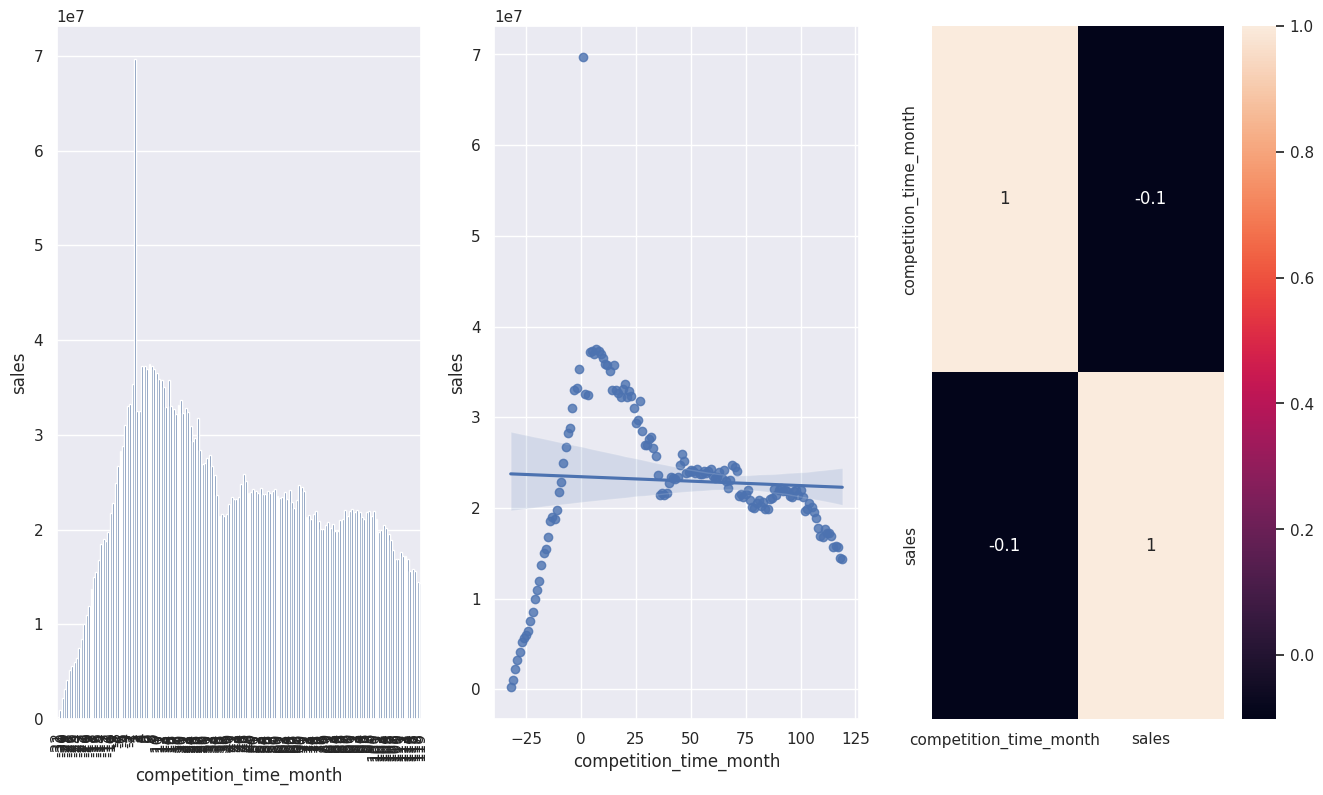

In [38]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[ (aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks( rotation=90);


plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
correlation = aux1.corr(method='pearson')
sns.heatmap( correlation, annot=True );

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
***FALSA*** Lojas com promocoes ATIVAS por mais tempo VENDEM MENOS, depois de um certo período de promocao

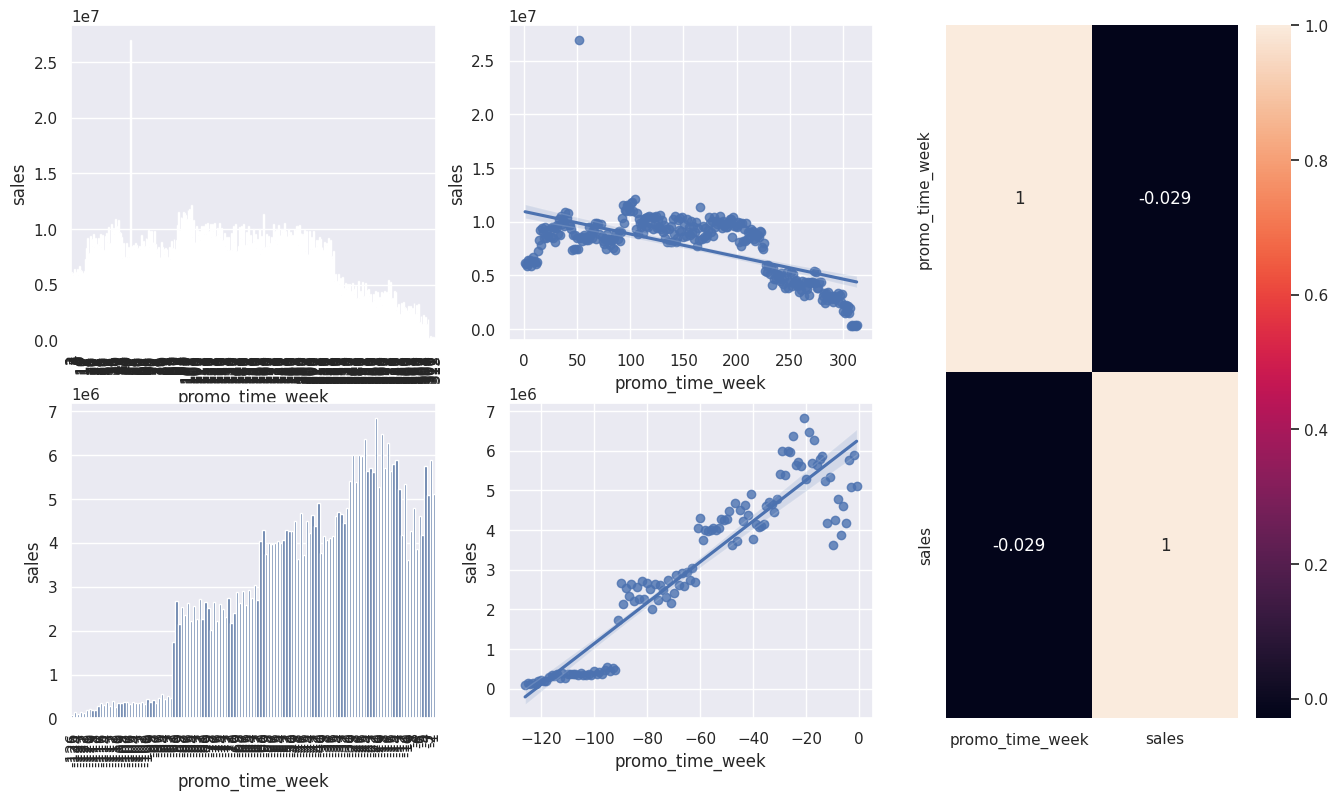

In [39]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

grid = gridspec.GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[ aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2)
plt.xticks( rotation=90);

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2)

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 )
plt.xticks( rotation=90);

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3);

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr(method='pearson'), annot=True);

### H5. Lojas com mais dias de promoção deveriam vender mais.

Hipotese será validada no 2º ciclo.

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
***FALSA*** Lojas com MAIS promocoes consecutivas VENDEM MENOS

In [40]:
aux1 = df4[[ 'promo', 'promo2', 'sales' ]].groupby( ['promo', 'promo2']).sum().reset_index()
aux1

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


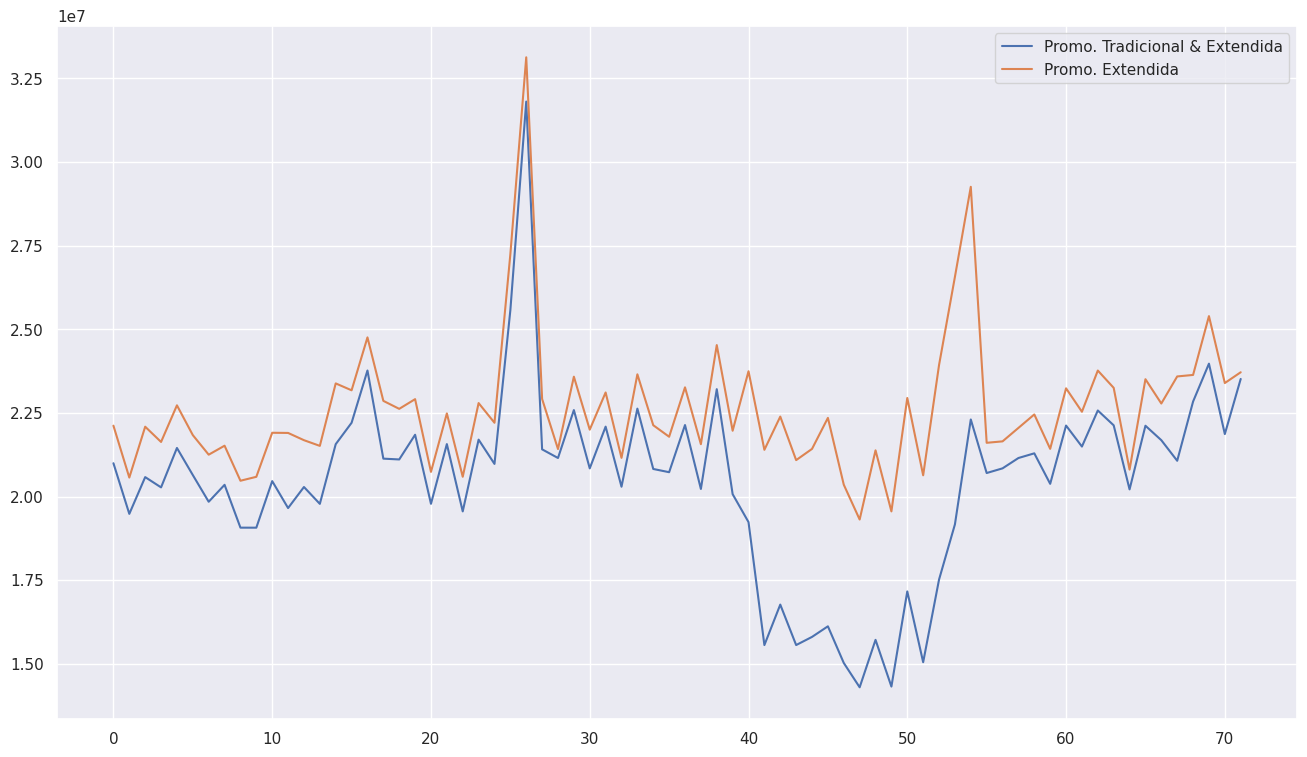

In [41]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax);

ax.legend( labels=['Promo. Tradicional & Extendida', 'Promo. Extendida']);

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSO** Lojas ABERTAS durante feriado de Natal VENDEM MENOS

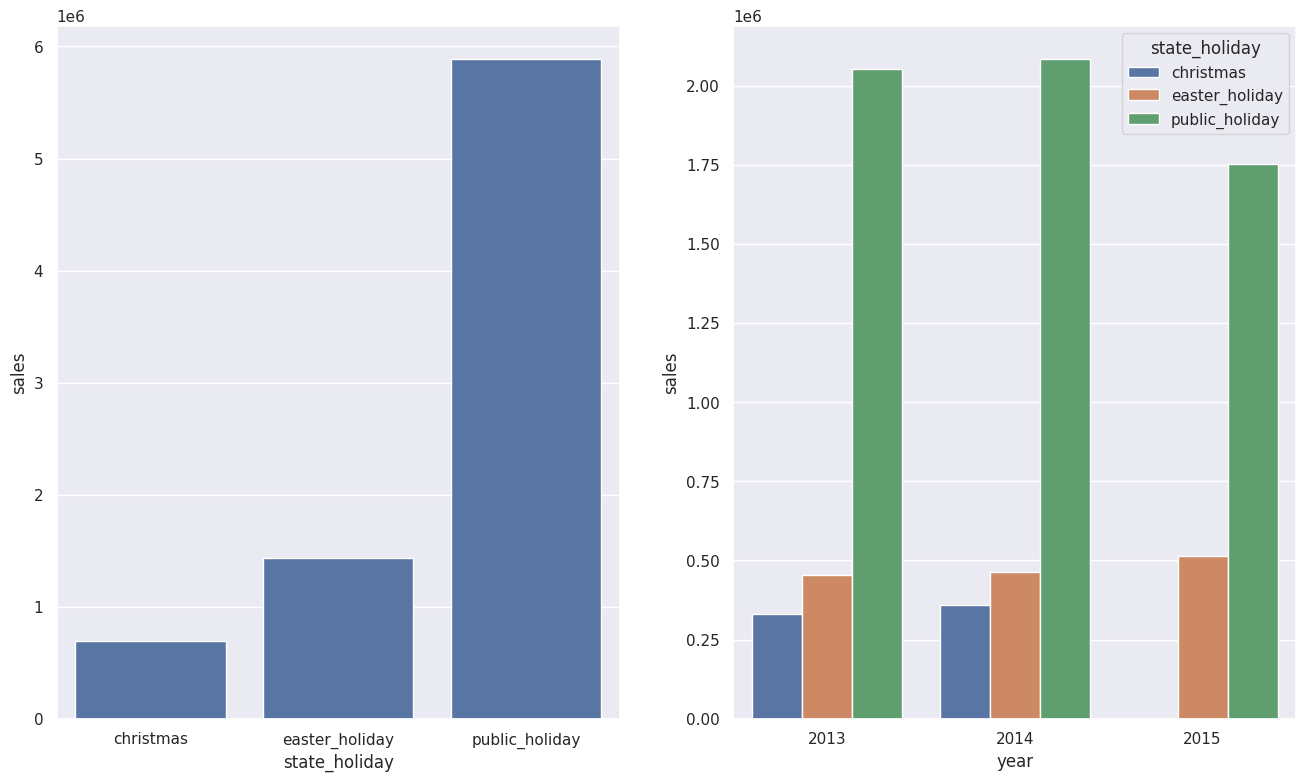

In [42]:
plt.subplot( 1,2,1 )
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1);

plt.subplot( 1,2,2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2);

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas VENDEM MENOS ao longo do TEMPO

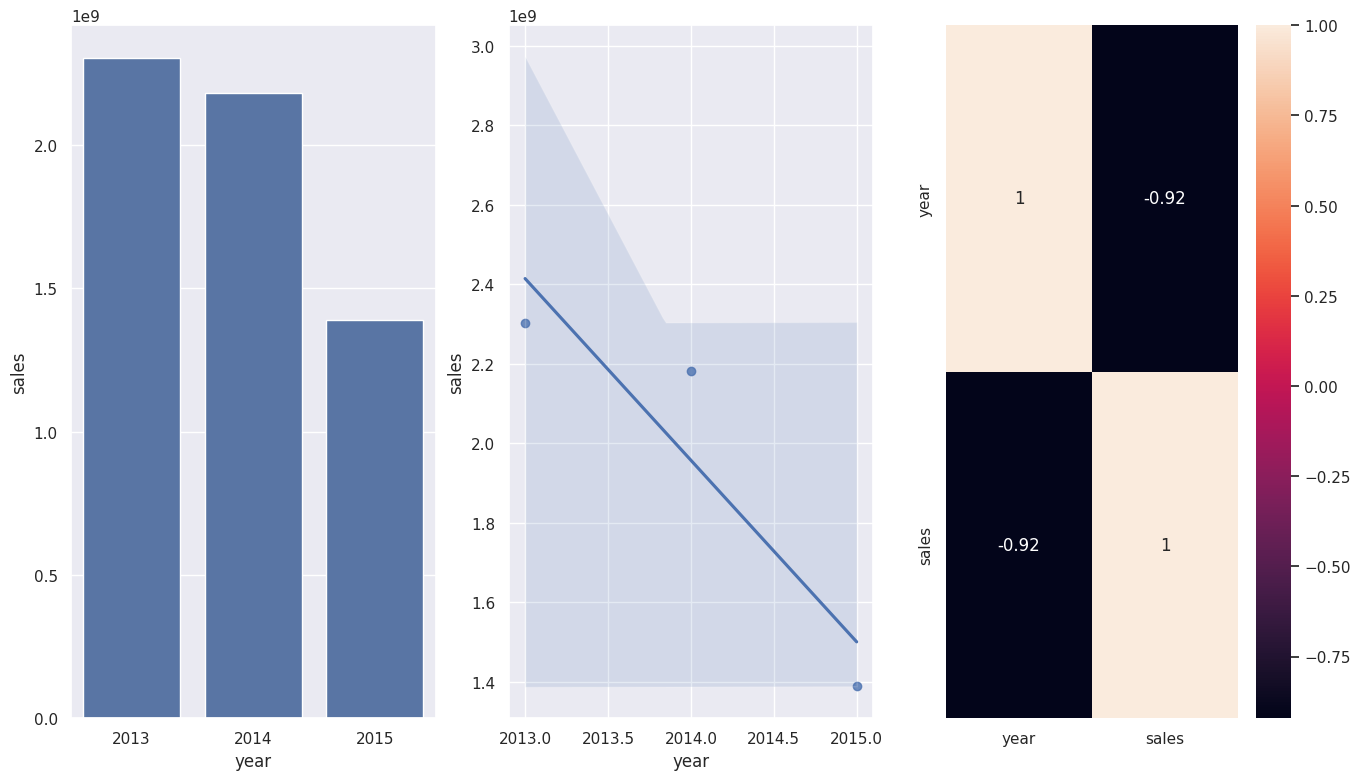

In [43]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot( 1,3,1 )
sns.barplot( x='year', y='sales', data=aux1);

plt.subplot( 1,3,2 )
sns.regplot( x='year', y='sales', data=aux1);

plt.subplot( 1,3,3 )
sns.heatmap( aux1.corr(method='pearson'), annot=True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSO** Lojas VENDEM MENOS no SEGUNDO SEMESTRE do ano

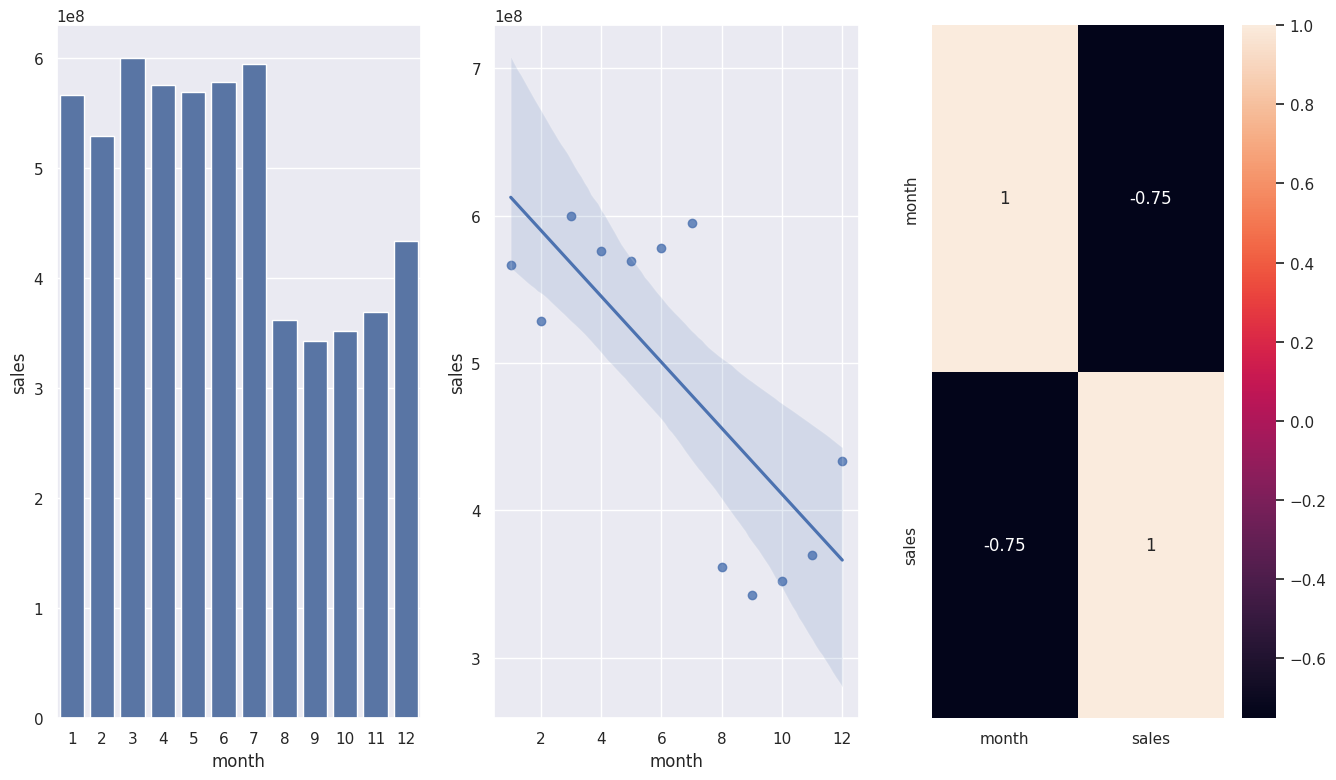

In [44]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr('pearson'), annot=True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas VENDEM MAIS depois do DIA 10 de cada mês.

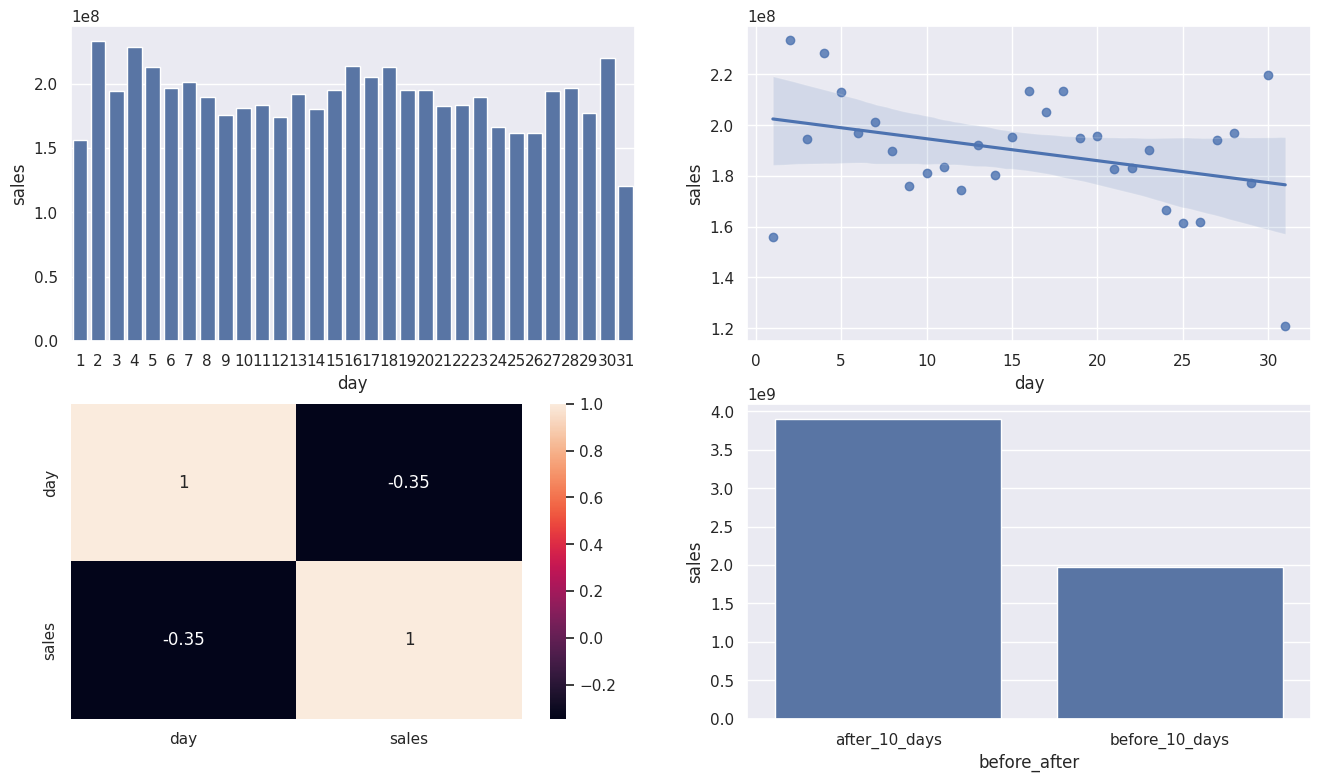

In [45]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2,2,1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2,2,2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2,2,3 )
sns.heatmap( aux1.corr('pearson'), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot( 2,2,4 )
sns.barplot(x='before_after', y='sales', data=aux2);

### **H11.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRO** Lojas VENDEM MENOS nos FINAIS DE SEMANA

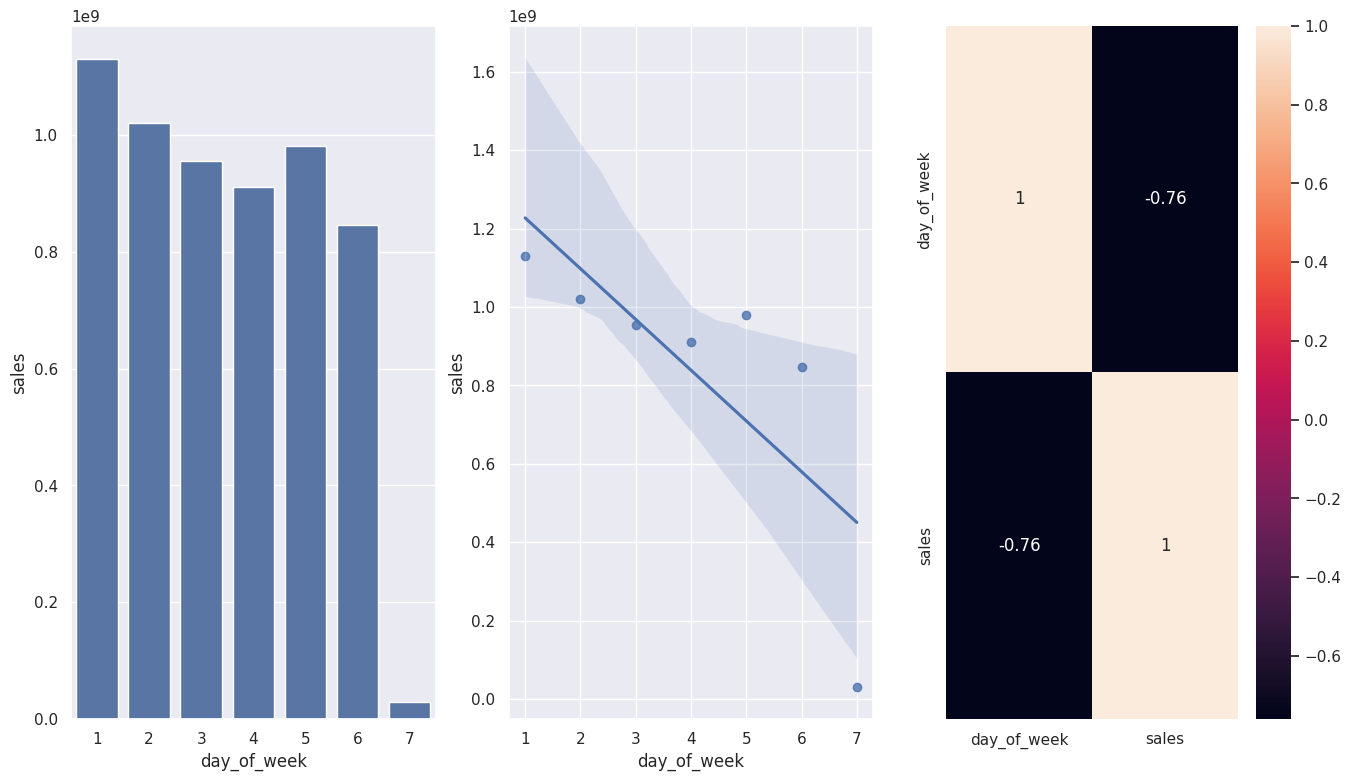

In [46]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot( 1,3,1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1,3,2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1,3,3 )
sns.heatmap( aux1.corr(method='pearson'), annot=True);

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas VENDEM MENOS durante os FERIADOS ESCOLARES, exceto nos meses de Julho e Agosto.

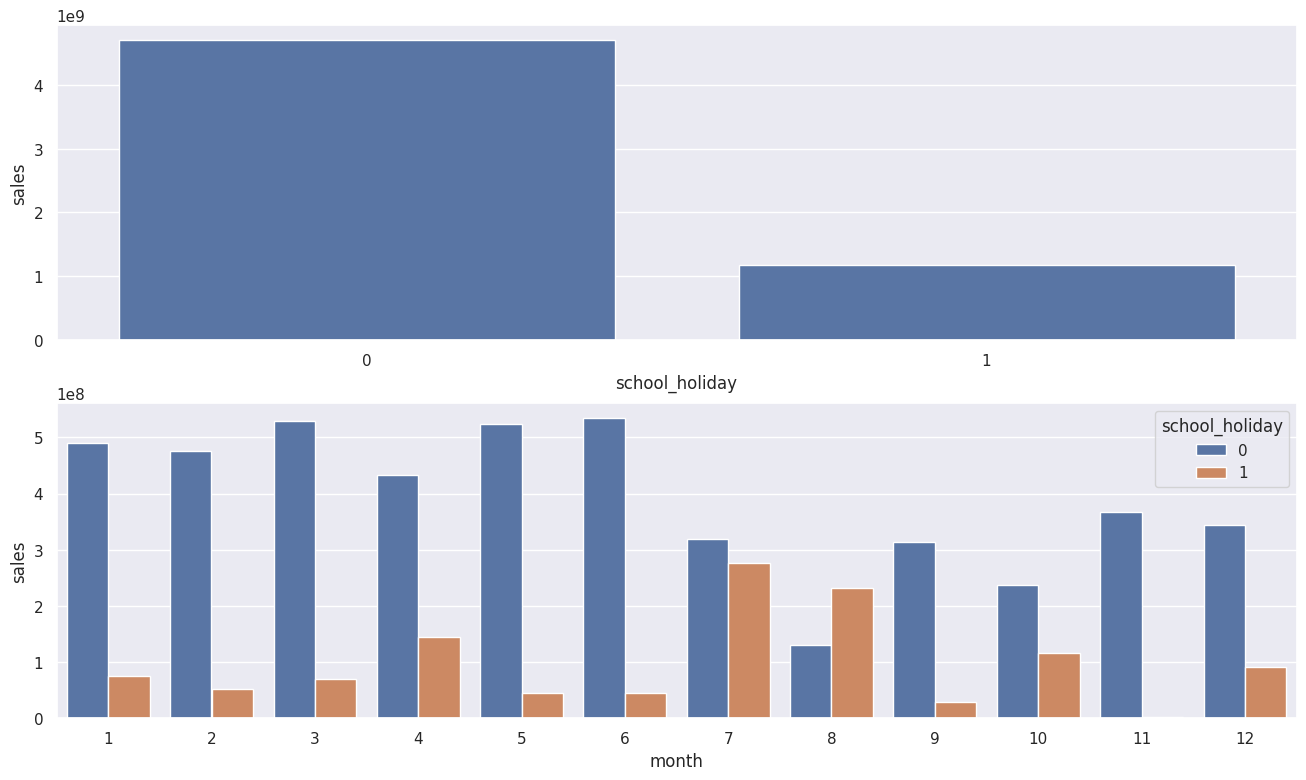

In [47]:
plt.subplot( 2, 1, 1 )
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot( x='school_holiday', y='sales', data=aux1 );

plt.subplot( 2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1. Resumo das Hipóteses

In [48]:
tab = [['Hipoteses', 'Conclusão', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Média'],
      ['H3', 'Falsa', 'Média'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Média'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Média'],
      ]
print( tabulate(tab, headers='firstrow') )

Hipoteses    Conclusão    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Média
H3           Falsa        Média
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Média
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Média


## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

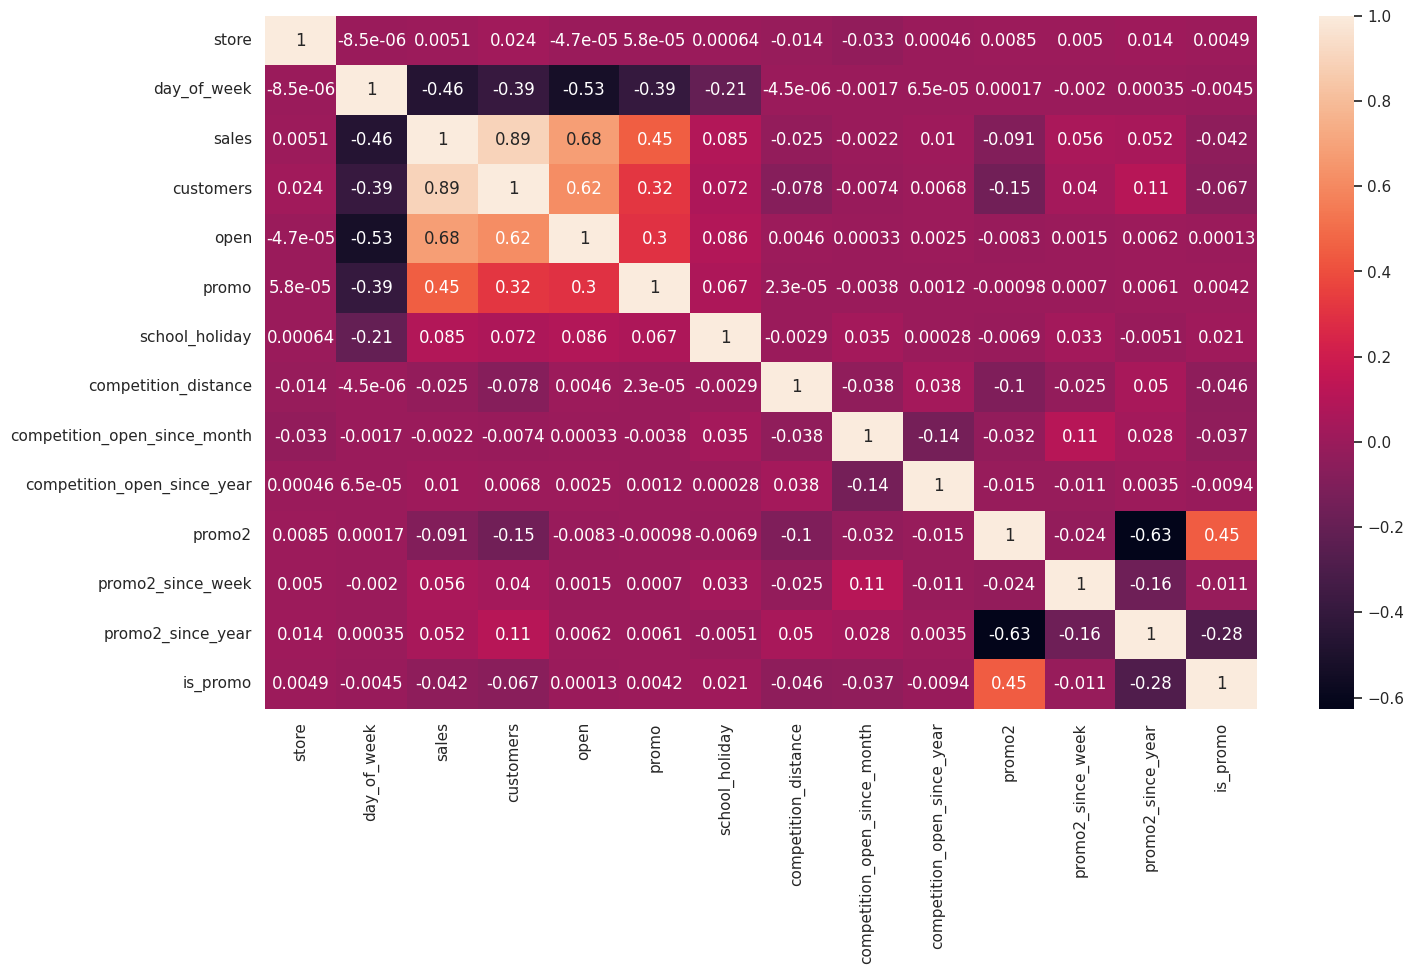

In [49]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True);

### 4.3.2. Categorical Attributes

In [50]:
a = df4.select_dtypes( include='object' )

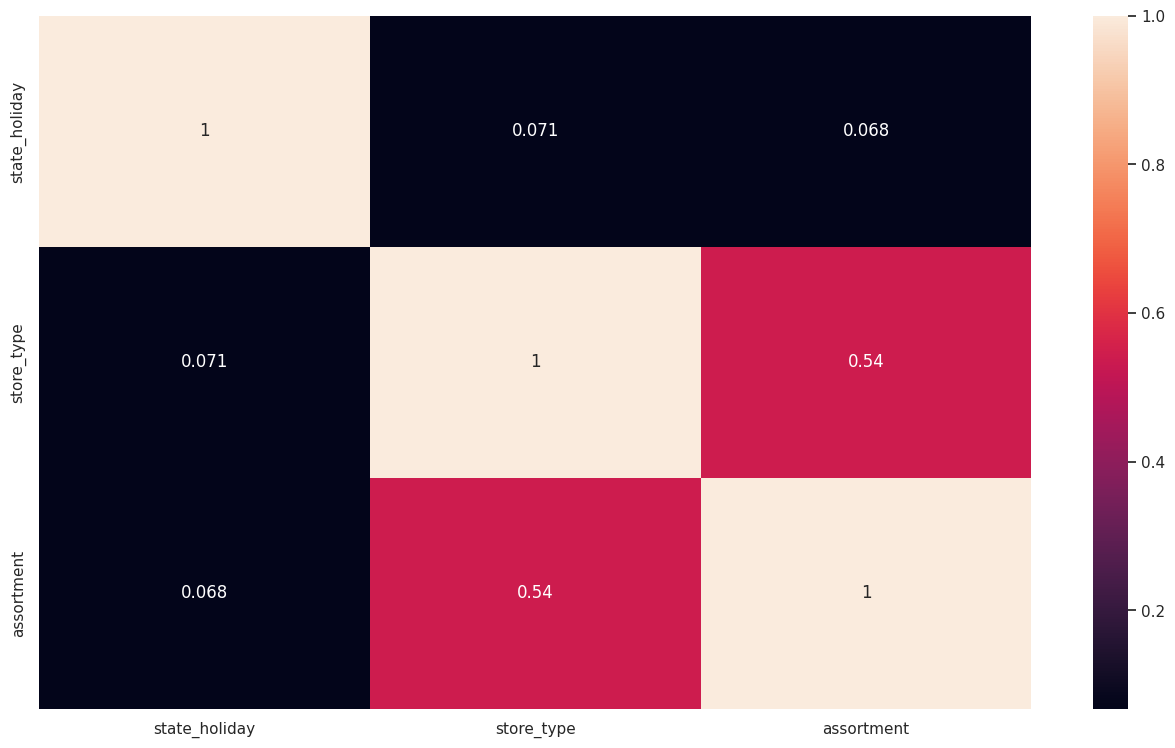

In [51]:
# Calculando craver V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )


# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type':    [a4, a5, a6], 
               'assortment':    [a7, a8, a9],} )

d = d.set_index( d.columns )

sns.heatmap(d, annot=True);

# 5.0. PASSO 05 - PREPARAÇÃO DOS DADOS

In [52]:
df5 = df4.copy()

## 5.1. Normalização

Foi analisada a seção 4.1.2 Analise Numérica e não foi localizado nenhuma variável com uma distribuição normal. 

A que chegou mais próxima de uma distribuição normal foi a "sales".

Então devido a isso, optei por não normalizar nada.

## 5.2. Rescaling

In [53]:
a = df5.select_dtypes( include=[ 'int64', 'float64' ] )
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,4,0


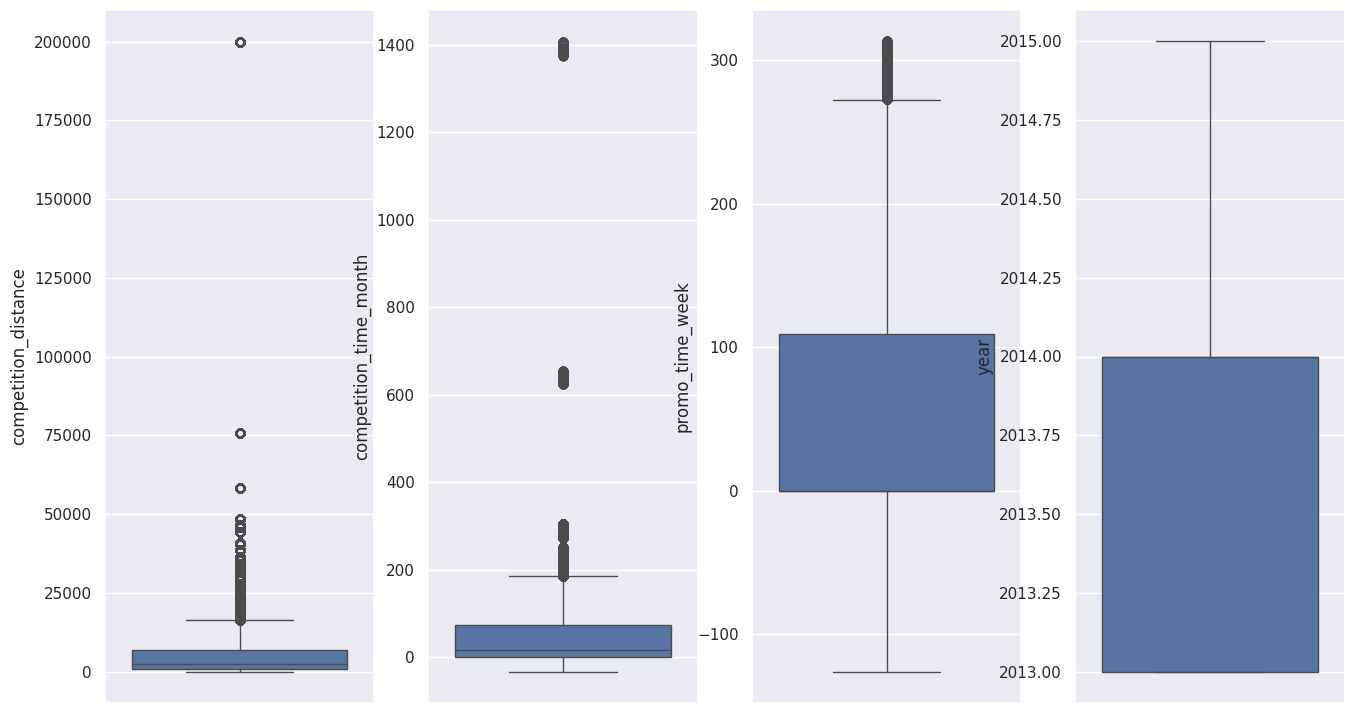

In [54]:
plt.subplot( 1, 4, 1 )
sns.boxplot( df5['competition_distance']);

plt.subplot( 1, 4, 2 )
sns.boxplot( df5['competition_time_month']);

plt.subplot( 1, 4, 3 )
sns.boxplot( df5['promo_time_week']);

plt.subplot( 1, 4, 4 )
sns.boxplot( df5['year']);

In [55]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb' ) )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb' ) )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb' ) )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb' ) )

## 5.3.Transformação

### 5.3.1. Encoding

In [56]:
# state holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

# store type -  Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb' ))

# assortment - Ordinal Encoding
assortment_dict = { 'basic': 1, 'extra': 2, 'extended':3 }
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation

In [57]:
df5['sales'] = np.log1p( df5['sales'])

### 5.3.3. Nature Transformation

In [58]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0. PASSO 06 - FEATURE SELECTION

In [59]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [60]:
cols_drop = [ 'week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [61]:
df6[['store', 'date']].groupby( 'store').max().reset_index()['date'][0] - datetime.timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [62]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( f"Training Min Date: {X_train['date'].min()}" )
print( f"Training Max Date: {X_train['date'].max()}" )

print( f"\nTest Min Date: {X_test['date'].min()}" )
print( f"Test Max Date: {X_test['date'].max()}" )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [63]:
# # training e test para Boruta
# X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
# y_train_n = y_train.values.ravel()


# # definicao RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1 )


# # definicao boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=77 ).fit( X_train_n, y_train_n )

### 6.2.1. Best Features do Boruta

In [64]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [65]:
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos']

In [66]:
cols_not_selected_boruta = [
 'is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_cos',
 'week_of_year_sin',
 'year']

## 6.3. Selecao Manual das Feature

In [67]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos']

# adicionar colunas
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

In [68]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [69]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales':'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2. Linear Regression Model

In [70]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1(y_test), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1868.255048,0.292406,2674.402343


### 7.2.1. Linear Regression Model - Cross Validation

In [71]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2080.51 +/- 292.95,0.3 +/- 0.02,2950.33 +/- 464.0


## 7.3. Linear Regression Regularized Model - Lasso

In [72]:
# model 
lrr = Lasso( alpha=0.001 ).fit( x_train, y_train )

# predict
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr) ) 
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1869.571858,0.288111,2694.005137


### 7.3.1. Linear Regression Regularized Model - Lasso - Cross Validation

In [73]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2088.84 +/- 327.02,0.3 +/- 0.01,2988.55 +/- 499.58


## 7.4. Random Forest Regressor

In [74]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=77 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,711.298991,0.105949,1043.778751


### 7.4.1 Random Forest Regressor - Cross Validation

In [75]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


 KFold Number: 5

 KFold Number: 4

 KFold Number: 3

 KFold Number: 2

 KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,848.28 +/- 230.62,0.12 +/- 0.02,1270.2 +/- 337.26


## 7.5. XGBoost Regressor

In [76]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators= 100,
                              eta= 0.3,
                              max_depth= 7,
                              subsample= 1,
                              colsample_bytree= 1 ).fit( x_train, y_train )
                                
# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,791.601905,0.117393,1142.011747


### 7.5.1. XGBoost Regressor - Cross Validation

In [77]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


 KFold Number: 5

 KFold Number: 4

 KFold Number: 3

 KFold Number: 2

 KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,994.87 +/- 164.2,0.14 +/- 0.02,1417.86 +/- 235.37


## 7.6. Compare Model's Performance

### 7.6.1 Single Performance

In [78]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,711.298991,0.105949,1043.778751
0,XGBoost Regressor,791.601905,0.117393,1142.011747
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1868.255048,0.292406,2674.402343
0,Linear Regression - Lasso,1869.571858,0.288111,2694.005137


### 7.6.1 Real Performance - Cross Validation

In [79]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2080.51 +/- 292.95,0.3 +/- 0.02,2950.33 +/- 464.0
0,Lasso,2088.84 +/- 327.02,0.3 +/- 0.01,2988.55 +/- 499.58
0,Random Forest Regressor,848.28 +/- 230.62,0.12 +/- 0.02,1270.2 +/- 337.26
0,XGBoost Regressor,994.87 +/- 164.2,0.14 +/- 0.02,1417.86 +/- 235.37


# 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [80]:
# param = {
#     'n_estimators': [1500, 1700, 2500, 3000, 3500 ],
#     'eta': [0.01, 0.03],
#     'max_depth': [3, 5, 9],
#     'subsample': [0.1, 0.5, 0.7],
#     'colsample_bytree': [0.3, 0.7, 0.9],
#     'min_child_weight': [3, 8, 15]
#         }

# max_eval = 5

In [81]:
# final_result = pd.DataFrame()

# for i in range( max_eval ):
#     # escolher valor dos parametros aleatoriamente
#     hp = { k: random.sample( v, 1)[0] for k, v in param.items()}
#     print( hp )
#     # model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                   n_estimators= hp['n_estimators'],
#                                   eta= hp['eta'],
#                                   max_depth= hp['max_depth'],
#                                   subsample= hp['subsample'],
#                                   colsample_bytree=hp['colsample_bytree'],
#                                   min_child_weight=hp['min_child_weight'] )
                                    

#     # performance
                                 
#     result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#     final_result = pd.concat( [final_result, result] )

# final_result

## 8.2. Final Model

In [108]:
param_tuned = {
    'n_estimators': 2500,
    'eta': 0.03,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
        }

In [109]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train)
# predict       
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance                
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,740.96934,0.110604,1072.017233


In [84]:
mean_percentage_error(  np.expm1( y_test ) , np.expm1( yhat_xgb_tuned ) )

-0.014785071925738594

# 9.0. PASSO 09 - INTERPRETAÇÃO E TRADUÇÃO DO ERRO

In [117]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

### 9.1. Business Performance

In [118]:
# Soma das predicoes
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mt.mean_absolute_error( x['sales'], x['predictions'] )).reset_index().rename( columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mt.mean_absolute_percentage_error( x['sales'], x['predictions'] )).reset_index().rename( columns={0: 'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Cenarios
df92['pior_cenario'] = df92['predictions'] - df92['MAE']
df92['melhor_cenario'] = df92['predictions'] + df92['MAE']

# Order columns
df92 = df92[['store', 'predictions', 'pior_cenario', 'melhor_cenario', 'MAE', 'MAPE']]

In [119]:
df92.sample(5)

,store,predictions,pior_cenario,melhor_cenario,MAE,MAPE
607,608,359912.500000,358980.330804,360844.669196,932.169196,0.101865
636,637,328483.218750,327472.453732,329493.983768,1010.765018,0.107525
368,369,241796.328125,241254.849068,242337.807182,541.479057,0.082785
885,886,247070.671875,246441.011244,247700.332506,629.660631,0.096435
475,476,217398.250000,216700.481353,218096.018647,697.768647,0.163357


In [120]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,pior_cenario,melhor_cenario,MAE,MAPE
291,292,107289.835938,103888.724507,110690.947368,3401.111431,0.601784
908,909,230294.906250,222571.836829,238017.975671,7723.069421,0.520405
901,902,200176.281250,198763.624842,201588.937658,1412.656408,0.356669
594,595,339212.156250,334076.998522,344347.313978,5135.157728,0.353460
169,170,199566.812500,198271.113440,200862.511560,1295.699060,0.322812


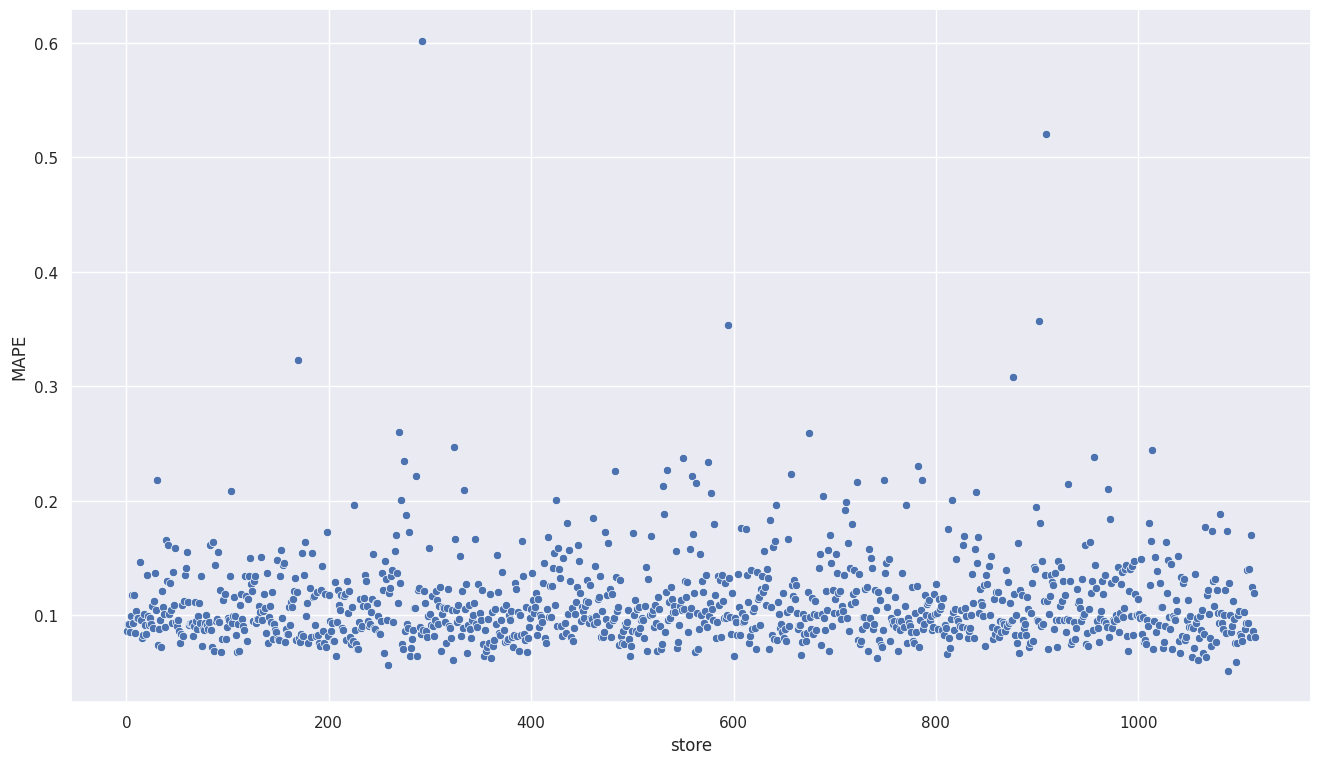

In [121]:
sns.scatterplot( x='store', y='MAPE', data=df92 );

### 9.2. Total Performance

In [122]:
df93 = df92[['predictions', 'pior_cenario', 'melhor_cenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Cenario', 0:'Valor'})
df93['Valor'] = df93['Valor'].map( 'R$ {:,.2f}'.format )
df93.head()

,Cenario,Valor
0,predictions,"R$ 288,153,824.00"
1,pior_cenario,"R$ 287,324,192.08"
2,melhor_cenario,"R$ 288,983,510.06"


### 9.3. Machine Learning Performance

In [123]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

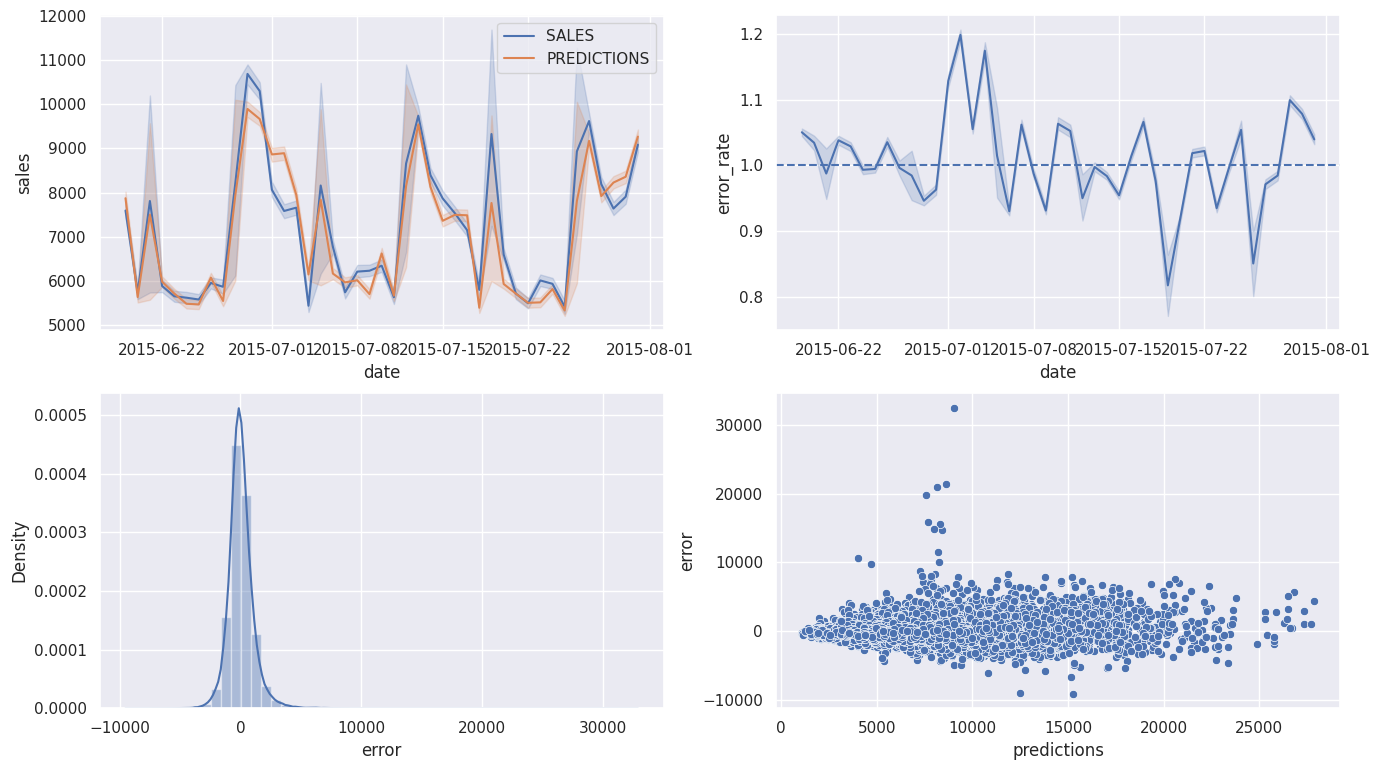

In [124]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--' )

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'])

plt.subplot( 2, 2, 4 )
sns.scatterplot( x=df9['predictions'], y=df9['error'] );

# 10. PASSO 10 - DEPLOY DO MODELO EM PRODUÇÃO

In [125]:
# Modelo treinado salvo
pickle.dump( model_xgb_tuned, open( '/home/dimarinho/repos/Data_Science_em_Producao/model/model_rossmann.pkl', 'wb' ))

## 10.1. Rossmann Class

In [111]:
pwd

'/home/dimarinho/repos/Data_Science_em_Producao'

In [112]:
import pandas as pd
import numpy  as np
import pickle
import inflection
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='/home/dimarinho/repos/Data_Science_em_Producao/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb' ) ) 
        self.competition_time_week_scaler  = pickle.load( open( self.home_path + 'parameter/competition_time_week_scaler.pkl', 'rb' ) )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb' ) )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb' ) )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb' ) )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb' ))

    def data_cleaning( self, df1 ):

        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
               'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
  
        #estilo minusculo separado por (_)
        snakecase = lambda x: inflection.underscore( x )
        
        # A funcao map faz o mapeamento da funcao snakecase em todas as palavras da cols_old
        cols_new = list( map(snakecase, cols_old) )
        
        # rename
        df1.columns = cols_new  

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )
         
        ## 1.5. Fillout NA 
        # fillma substitui os valores da coluna por 0 e o inplace=True, faz a modificacao direto na coluna
        
        # promo2_since_year 
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1)
        
        # promo2_since_week
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)
        
        # competition_open_since_year   
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )
        
        # competition_open_since_month    
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
        
        # competition_distance       
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        # promo_interval      
        month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }
        
        df1['promo_interval'].fillna(0, inplace=True)
        
        df1['month_map'] = df1['date'].dt.month.map( month_map )
        
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )
        
        ## 1.6. Change Types
        # competition
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        
        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

        return df1

    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year
        
        # month
        df2['month'] = df2['date'].dt.month
        
        # day
        df2['day'] = df2['date'].dt.day
        
        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week
        
        # year of week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )
        
        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30).apply( lambda x: x.days ).astype( int )
        
        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7 ).apply( lambda x: x.days).astype(int)
        
        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b'  else 'extended' )
        
        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )
        
        ## 3.1. Filtragem das Linhas
        df2 = df2[ (df2['open']  != 0) ]
        
        ## 3.2. Seleção das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
    
        return df2

    def data_preparation( self, df5 ):

        ## 5.2. Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
        
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store type -  Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )
        
        # assortment - Ordinal Encoding
        assortment_dict = { 'basic': 1, 'extra': 2, 'extended':3 }
        df5['assortment'] = df5['assortment'].map( assortment_dict )


        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )
        
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )
        
        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )
        
        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

        cols_selected = [ 'store', 'promo','store_type', 'assortment',  'competition_distance', 'competition_open_since_month', 
                                'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 
                                'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos']

        return df5[ cols_selected ]

    def get_prediction( self, model, original_data, test_data ):
        # predicition
        pred = model.predict( test_data )

        # join pred com dados originais
        original_data['prediction'] = np.expm1( pred )

        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler

In [126]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( '/home/dimarinho/repos/Data_Science_em_Producao/model/model_rossmann.pkl', 'rb' ) )

# iniciando API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['GET', 'POST'] )
def rossmann_predict():
    test_json = request.get_json()

    if test_json: # tem dados
        if isinstance( test_json, dict ): # exemplo unico
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # exemplos multiplos
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )

        # Instanciar Classe Rossmann
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )

        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )

        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
        

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## 10.3. API Tester

In [146]:
df10 = pd.read_csv( '/home/dimarinho/repos/Data_Science_em_Producao/datasets/test.csv' )

In [147]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# escolher store para predicao
df_test = df_test[df_test['Store'].isin([12, 22, 24, 30, 37, 45, 59, 63, 72])]

# remover dias fechados
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [148]:
# Convertendo DataFrame em JSON
data = json.dumps( df_test.to_dict( orient='records' ))

In [149]:
# API Call
# url = 'http://127.0.0.1:5000/rossmann/predict'
url = 'https://api-rossmann-edinan-marinho.onrender.com/rossmann/predict' # lembre-se de colocar o endpoint 'rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post( url, data=data, headers=header )
print( f'Status Code { r.status_code }' )

Status Code 200


In [150]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [151]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print(f"Loja número {d2.loc[i, 'store']} venderá R$ {d2.loc[i, 'prediction']:,.2f} nas próximas 6 semanas")

Loja número 12 venderá R$ 252,717.48 nas próximas 6 semanas
Loja número 22 venderá R$ 155,427.28 nas próximas 6 semanas
Loja número 24 venderá R$ 316,073.61 nas próximas 6 semanas
Loja número 30 venderá R$ 192,383.17 nas próximas 6 semanas
Loja número 45 venderá R$ 229,526.37 nas próximas 6 semanas
Loja número 63 venderá R$ 389,593.47 nas próximas 6 semanas
Loja número 72 venderá R$ 167,429.41 nas próximas 6 semanas
